In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import math
import time

### Create simulated dataset

In [2]:
def apply_translation(points, tx, ty):
    return points + np.array([tx, ty])

def apply_rotation(points, angle):
    radians = np.deg2rad(angle)
    cos_a, sin_a = np.cos(radians), np.sin(radians)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    return np.dot(points, rotation_matrix)

def apply_scaling(points, scale_x, scale_y):
    return points * np.array([scale_x, scale_y])

def generate_stationary_points(num_points):
    # Define stationary points in a fixed reference frame
    return np.random.uniform(-1, 1, size=(num_points, 2))

def generate_smooth_transformations(num_frames, tx_range, ty_range, angle_range, scale_range):
    tx = np.linspace(tx_range[0], tx_range[1], num_frames)
    ty = np.linspace(ty_range[0], ty_range[1], num_frames)
    angles = np.linspace(angle_range[0], angle_range[1], num_frames)
    scales_x = np.linspace(scale_range[0], scale_range[1], num_frames)
    scales_y = np.linspace(scale_range[0], scale_range[1], num_frames)
    
    return tx, ty, angles, scales_x, scales_y

def generate_dataframe(num_frames, stationary_points, tx_range, ty_range, angle_range, scale_range):
    num_points = stationary_points.shape[0]
    tx, ty, angles, scales_x, scales_y = generate_smooth_transformations(num_frames, tx_range, ty_range, angle_range, scale_range)
    
    data = []

    for t in range(num_frames):
        # Apply transformations to the stationary points
        transformed_points = apply_scaling(stationary_points, scales_x[t], scales_y[t])
        transformed_points = apply_rotation(transformed_points, angles[t])
        transformed_points = apply_translation(transformed_points, tx[t], ty[t])
        
        # Append to the data list
        for idx in range(num_points):
            x, y = transformed_points[idx]
            data.append([t, idx, x, y])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=['frame', 'idx', 'x', 'y'])
    
    return df

def introduce_missing_frames(df, idx, n_segments=2, p_switch=0.8, max_id=8):
    frames = np.unique(df['frame'])
    mask = np.zeros(len(frames), dtype=bool)
    
    start_misses = np.random.choice(frames, size=n_segments)
    miss_duration = np.random.randint(10,510, size=n_segments)
    
    for start, duration in zip(start_misses, miss_duration):
        end = start + duration
        mask[start:end] = True
    
    valid_frames = np.where(mask)[0]
    condition_to_drop = (df['idx'] == idx) & (df['frame'].isin(valid_frames))

    df = df[~condition_to_drop].reset_index(drop=True)
    
    # Switch id after missing frames
    if np.random.uniform() < p_switch:
        switch_idx = np.random.randint(0,n_segments)
        switch_after_frame = start_misses[switch_idx] + miss_duration[switch_idx]
        
        df.loc[(df['idx'] == idx) & (df['frame'] > switch_after_frame), 'idx'] = max_id+1
        
        max_id+=1
    
    return df,max_id

In [3]:
# Parameters
num_points = 50
num_frames = 5820

stationary_points = generate_stationary_points(num_points)
df = generate_dataframe(num_frames, stationary_points, (-2, 2), (-5, 5), (-90, 90), (0.5, 2.))

In [4]:
all_ids = np.unique(df['idx'])
max_id = np.max(all_ids)
for idx in all_ids:
    df,max_id = introduce_missing_frames(df, idx, n_segments=2, p_switch=0.4, max_id=max_id)
    
df.head()

,frame,idx,x,y
0,0,0,-1.575764,-4.699298
1,0,1,-1.743336,-4.840043
2,0,2,-1.951206,-4.581745
3,0,3,-2.179039,-5.456113
4,0,4,-2.369334,-5.117581


### Import tracking data

In [3]:
df = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/Python/SpatialRegistration/tracksp1d1.csv')
df['x'] = df['bb_left'] + df['bb_width']/2
df['y'] = df['bb_top'] + df['bb_height']/2
df['idx'] = df['track_id']

df = df.loc[:,['frame', 'x', 'y', 'idx']]
df.head()

,frame,x,y,idx
0,0,3231.399,58.680,1
1,0,1596.498,174.696,2
2,0,3602.919,276.867,3
3,0,2578.536,318.834,4
4,0,1220.571,437.763,5


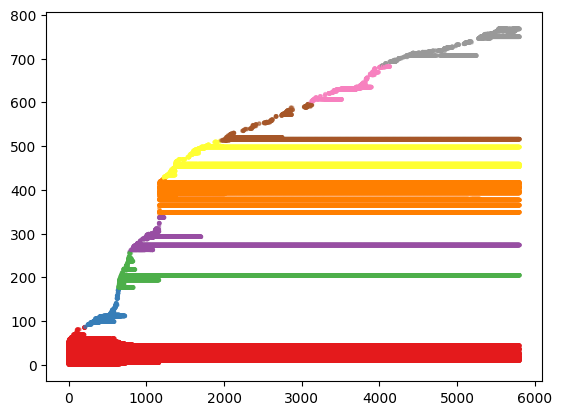

In [4]:
plt.scatter(df['frame'], df['idx'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)

### Apply homography

In [5]:
# Function to compute homography and extract translation, rotation, and scale
def compute_translation_rotation_scale(H):
    # Extract translation in x and y
    t_x = H[0, 2]
    t_y = H[1, 2]
    translation_xy = np.sqrt(t_x**2 + t_y**2)
    
    # Extract rotation angle from the top-left 2x2 submatrix
    r_11, r_21 = H[0, 0], H[1, 0]
    rotation_angle = math.atan2(r_21, r_11) * (180 / np.pi)  # convert to degrees
    
    # Extract scale factor from H[2, 2]
    scale_factor = 1 / H[2, 2]  # Inverse of the bottom-right value
    
    return translation_xy, rotation_angle, scale_factor

def identify_anchor_frames(df, thresholds):
    start_time = time.time()
    
    # Initialize variables
    anchor_frames = [0]  # Start with frame 0 as the first anchor frame
    
    # Get unique frames, sorted to process in order
    unique_frames = sorted(df['frame'].unique())
    
    # Set initial anchor frame
    anchor_frame = 0
    
    for frame in unique_frames:
        if frame == anchor_frame:
            continue
        
        # Get points in the current frame and anchor frame
        current_points = df[df['frame'] == frame][['idx', 'x', 'y']]
        anchor_points = df[df['frame'] == anchor_frame][['idx', 'x', 'y']]
        
        # Merge points on 'idx' to get corresponding points
        merged_points = pd.merge(current_points, anchor_points, on='idx', suffixes=('_current', '_anchor'))
        
        if len(merged_points) < 4:
            print(f"Not enough matching points for homography between frame {anchor_frame} and frame {frame}.")
            continue
        
        src_pts = merged_points[['x_anchor', 'y_anchor']].values
        dst_pts = merged_points[['x_current', 'y_current']].values
        
        # Apply RANSAC to find homography
        try:
            H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
        except cv2.error as e:
            print(f"Homography calculation failed between frame {anchor_frame} and frame {frame}: {e}")
            continue
        
        # Calculate translation, rotation, and scale
        translation_xy, rotation_angle, scale_factor = compute_translation_rotation_scale(H)
        
        # Determine if the thresholds are exceeded
        threshold_exceeded = (translation_xy > thresholds['T_translation']) or \
                             (abs(rotation_angle) > thresholds['T_rotation']) or \
                             (abs(scale_factor - 1) > thresholds['T_scale'])
                             
        if threshold_exceeded:
            anchor_frames.append(frame)
            anchor_frame = frame  # Update the anchor frame
    
    end_time = time.time()
    print(end_time - start_time)
    
    return anchor_frames

In [6]:
def find_best_anchor_for_each_frame(df, anchor_frames, thresholds):
    start_time = time.time()
    
    # Create a new column to store the best anchor frame for each frame
    df['best_anchor_frame'] = np.nan
    
    # Loop through all frames
    unique_frames = sorted(df['frame'].unique())
    
    for frame in unique_frames:
        # If the frame itself is an anchor, set itself as the anchor
        if frame in anchor_frames:
            df.loc[df['frame'] == frame, 'best_anchor_frame'] = frame
            continue
        
        # Compare against all preceding anchor frames
        best_anchor = None
        best_inliers = 0  # To keep track of the best match based on inliers
        
        for anchor_frame in anchor_frames:
            # Get points in the current frame and the candidate anchor frame
            current_points = df[df['frame'] == frame][['idx', 'x', 'y']]
            anchor_points = df[df['frame'] == anchor_frame][['idx', 'x', 'y']]
            
            # Merge points on 'idx' to get corresponding points
            merged_points = pd.merge(current_points, anchor_points, on='idx', suffixes=('_current', '_anchor'))
            
            if len(merged_points) < 4:
                continue  # Skip if not enough points to calculate homography
            
            src_pts = merged_points[['x_anchor', 'y_anchor']].values
            dst_pts = merged_points[['x_current', 'y_current']].values
            
            # Apply RANSAC to find homography
            try:
                H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
                inliers_count = np.sum(mask)  # Number of inliers
            except cv2.error as e:
                continue  # Skip if homography calculation failed
            
            # If this anchor frame gives more inliers, choose it as the best anchor
            if inliers_count > best_inliers:
                best_anchor = anchor_frame
                best_inliers = inliers_count
        
        # Assign the best anchor for the current frame
        if best_anchor is not None:
            df.loc[df['frame'] == frame, 'best_anchor_frame'] = best_anchor
    
    end_time = time.time()
    print(end_time - start_time)
    
    return df

In [7]:
def apply_homography_to_best_anchor(df):
    start_time = time.time()
    
    homography_matrices = {}  # Dictionary to store homography matrices
    
    # Initialize with the identity matrix for frame 0
    identity_matrix = np.eye(3)
    homography_matrices[0] = identity_matrix  # Frame 0 is its own anchor
    
    df['transformed_x'] = np.nan
    df['transformed_y'] = np.nan
    
    unique_frames = sorted(df['frame'].unique())
    
    for frame in unique_frames:
        best_anchor_frame = df.loc[df['frame'] == frame, 'best_anchor_frame'].values[0]
        
        if frame == best_anchor_frame:
            # If the frame is its own anchor, copy the coordinates directly
            df.loc[df['frame'] == frame, 'transformed_x'] = df['x']
            df.loc[df['frame'] == frame, 'transformed_y'] = df['y']
            
            # Store identity matrix for this frame in the dictionary
            homography_matrices[frame] = identity_matrix
            continue
        
        # Get points in the current frame and its best anchor frame
        current_points = df[df['frame'] == frame][['idx', 'x', 'y']]
        anchor_points = df[df['frame'] == best_anchor_frame][['idx', 'x', 'y']]
        
        # Merge points on 'idx' to get corresponding points
        merged_points = pd.merge(current_points, anchor_points, on='idx', suffixes=('_current', '_anchor'))
        
        if len(merged_points) < 4:
            print(f"Not enough matching points for homography between frame {best_anchor_frame} and frame {frame}.")
            continue
        
        src_pts = merged_points[['x_anchor', 'y_anchor']].values
        dst_pts = merged_points[['x_current', 'y_current']].values
        
        # Apply RANSAC to find homography
        try:
            H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
            homography_matrices[frame] = H  # Store the homography matrix for this frame
        except cv2.error as e:
            print(f"Homography calculation failed between frame {best_anchor_frame} and frame {frame}: {e}")
            continue
        
        # Transform the points using the homography matrix
        transformed_pts = cv2.perspectiveTransform(np.array([current_points[['x', 'y']].values], dtype=np.float32), H)[0]
        
        # Update DataFrame with transformed coordinates
        df.loc[df['frame'] == frame, 'transformed_x'] = transformed_pts[:, 0]
        df.loc[df['frame'] == frame, 'transformed_y'] = transformed_pts[:, 1]
    
    end_time = time.time()
    print(end_time - start_time)
    
    return df, homography_matrices

In [8]:
# Thresholds for translation, rotation, and scale
thresholds = {
    'T_translation': 50,  # e.g., 50 pixels
    'T_rotation': 10,      # e.g., 10 degrees
    'T_scale': 0.1        # e.g., 10% change
}

In [ ]:
# Step 1: Identify anchor frames
anchor_frames = identify_anchor_frames(df, thresholds)

# Step 2: Find the best anchor for each frame
df = find_best_anchor_for_each_frame(df, anchor_frames, thresholds)

# Step 3: Apply homography using the best anchor for each frame
df, homography_matrices = apply_homography_to_best_anchor(df)

df.head()

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.scatter(df['x'], df['y'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)
ax2.scatter(df['transformed_x'], df['transformed_y'], c=df['idx'], cmap='Set1', s=5, alpha=0.4)

plt.show()

In [ ]:
plt.scatter(df['frame'], df['best_anchor_frame'], s=5)
plt.plot(np.linspace(0,df['frame'].max()), np.linspace(0,df['frame'].max()), c='black')

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.scatter(df.loc[df['best_anchor_frame'] == 0, 'x'], df.loc[df['best_anchor_frame'] == 0, 'y'], c=df.loc[df['best_anchor_frame'] == 0, 'frame'], s=5)
ax2.scatter(df.loc[df['best_anchor_frame'] == 0, 'transformed_x'], df.loc[df['best_anchor_frame'] == 0, 'transformed_y'], c=df.loc[df['best_anchor_frame'] == 0, 'frame'], s=5)

plt.show()